## Data Dictionary
Variable | Definition | Key
---------|------------|--------
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age | Age in years	
sibsp | # of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


## Variable Notes
`pclass`: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Setup

In [262]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Investigations

In [302]:
# read raw
# raw_df = pd.read_csv('/kaggle/input/titanic/train.csv')
raw_df = pd.read_csv('./data/train.csv')


In [308]:
def val_contains_any(val, list):
    for item in list:
        if item in val:
            return True
    return False
def is_parent(row):
    if row['Parch'] > 0:
        if (row['is_age_mister'] == 1) or (row['is_age_misses'] == 1):
            return True
    return False
def is_child(row):
    if row['Parch'] > 0:
        if (row['is_age_master'] == 1) or (row['is_age_miss'] == 1):
            return True
    return False
        
df = raw_df
df['is_female']           = df["Sex"].map(lambda x: 1 if x == "female" else 0)

df['has_raw_age']         = df["Age"].map(lambda x: 1 if x > 0 else 0)
df['is_age_estimated']    = df["Age"].map(lambda x: 1 if ".5" in str(x) else 0)
df['is_age_infant']       = df["Age"].map(lambda x: 1 if x < 1 else 0)
df['is_age_child']        = df["Age"].map(lambda x: 1 if x >= 1 and x < 13 else 0)
df['is_age_teen']         = df["Age"].map(lambda x: 1 if x >= 13 and x < 20 else 0)
df['is_age_young_adult']  = df["Age"].map(lambda x: 1 if x >= 20 and x < 27 else 0)
df['is_age_adult']        = df["Age"].map(lambda x: 1 if x >= 27 and x < 45 else 0)
df['is_age_old_adult']    = df["Age"].map(lambda x: 1 if x >= 45 and x < 65 else 0)
df['is_age_elderly']      = df["Age"].map(lambda x: 1 if x >= 65 else 0)
# age groups
df['is_age_master']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Master."]) else 0)
df['is_age_mister']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Mr.", "Mister.","Dr.","Don.","Rev.","Col.","Capt.","Major.","Sir.","Jonkheer."]) else 0)
df['is_age_miss']         = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Miss.","Ms.","Mlle."]) else 0)
df['is_age_misses']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Mrs.","Mme.","Countess.","Lady."]) else 0)
df['raw_age']             = df['Age']

master_age_mean           = df[(df['is_age_master'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()
mister_age_mean           = df[(df['is_age_mister'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()
miss_age_mean             = df[(df['is_age_miss'] == 1)   & (df["has_raw_age"] == 1)]['Age'].mean()
misses_age_mean           = df[(df['is_age_misses'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()

df['Age']                 = np.where((df['is_age_master']==1) & (df['Age'].isna()), master_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_mister']==1) & (df['Age'].isna()), mister_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_miss']==1)   & (df['Age'].isna()), miss_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_misses']==1) & (df['Age'].isna()), misses_age_mean, df['Age'])

df['is_family']           = df.apply(lambda x: 1 if x['SibSp'] > 0 or x['Parch'] > 0 else 0, axis=1)
df['is_parent']           = df.apply(lambda x: 1 if is_parent(x) else 0, axis=1)
df['is_child']            = df.apply(lambda x: 1 if is_child(x) else 0, axis=1)

# 2 people with no embarked are hard to match with other values, drop them
df                        = df[df["Embarked"].isna() == False]


In [309]:
    # 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
    # 'Fare', 'Cabin', 'Embarked', 'is_female',
    # 'has_raw_age', 'is_age_estimated', 'is_age_infant', 'is_age_child',
    # 'is_age_teen', 'is_age_young_adult', 'is_age_adult', 'is_age_old_adult',
    # 'is_age_elderly', 'is_age_master', 'is_age_mister', 'is_age_miss',
    # 'is_age_misses', 'raw_age', 'is_family'
    # 'SibSp', 'Parch', 
# trmming down
df = df.drop(columns=['PassengerId', 'Name', 'Sex', 'Age', 'Ticket', 
                      'Cabin', 'raw_age', 
                      'has_raw_age','is_age_estimated',
                      'SibSp', 'Parch'])


In [310]:
df['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 247, dtype: int64

In [311]:
# ## Prove that our Age Groups all have Ages

# def get_age_groups(df, field):
#     all_df = df[df[field] == 1]
#     no_age_df = all_df[all_df["Age"].isna()]
#     age_df = all_df[all_df["Age"].isna() == False]
#     return all_df, age_df, no_age_df

# def print_lengths(pref, all_df, age_df, no_age_df):
#     print(f"{pref:>6} a:{len(all_df):>6} w:{len(age_df):>6} no:{len(no_age_df):>6}")
    
# (masters_df, masters_age_df, masters_no_age_df) = get_age_groups(df, "is_age_master")
# (misters_df, misters_age_df, misters_no_age_df) = get_age_groups(df, "is_age_mister")
# (miss_df, miss_age_df, miss_no_age_df) = get_age_groups(df, "is_age_miss")
# (misses_df, misses_age_df, misses_no_age_df) = get_age_groups(df, "is_age_misses")

# print_lengths("master", masters_df, masters_age_df, masters_no_age_df)
# print_lengths("mr", misters_df, misters_age_df, misters_no_age_df)
# print_lengths("miss", miss_df, miss_age_df, miss_no_age_df)
# print_lengths("mrs", misses_df, misses_age_df, misses_no_age_df)
                  
# print(f"{len(masters_df) + len(misters_df) + len(miss_df) + len(misses_df) }  total by breakdown")
# print(f"{len(df) }  total raw")

# Investigations

In [314]:
df.head()

,Survived,Pclass,Fare,Embarked,is_female,is_age_infant,is_age_child,is_age_teen,is_age_young_adult,is_age_adult,is_age_old_adult,is_age_elderly,is_age_master,is_age_mister,is_age_miss,is_age_misses,is_family,is_parent,is_child
0,0,3,7.2500,S,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,1,1,71.2833,C,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0
2,1,3,7.9250,S,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,1,53.1000,S,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0
4,0,3,8.0500,S,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [315]:
df.count()

Survived              889
Pclass                889
Fare                  889
Embarked              889
is_female             889
is_age_infant         889
is_age_child          889
is_age_teen           889
is_age_young_adult    889
is_age_adult          889
is_age_old_adult      889
is_age_elderly        889
is_age_master         889
is_age_mister         889
is_age_miss           889
is_age_misses         889
is_family             889
is_parent             889
is_child              889
dtype: int64

# Investigations

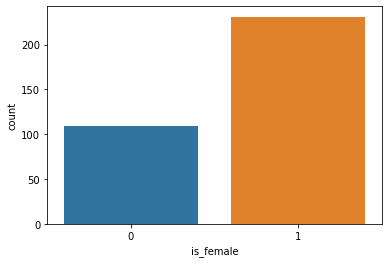

In [316]:
surv_df = df[df["Survived"] == 1]
ax = sns.countplot(x="is_female", data=surv_df)
# surv_df["Sex"].value_counts().plot(kind="bar")

In [317]:
def count_plot(df, field, title_prefix="Survived"):
    plt.figure(figsize=(20,5),dpi=100)
    sns.countplot(x=field, 
                  data=surv_df, 
                        order=surv_df[field].value_counts().index).set_title(f"{title_prefix} : {field}")

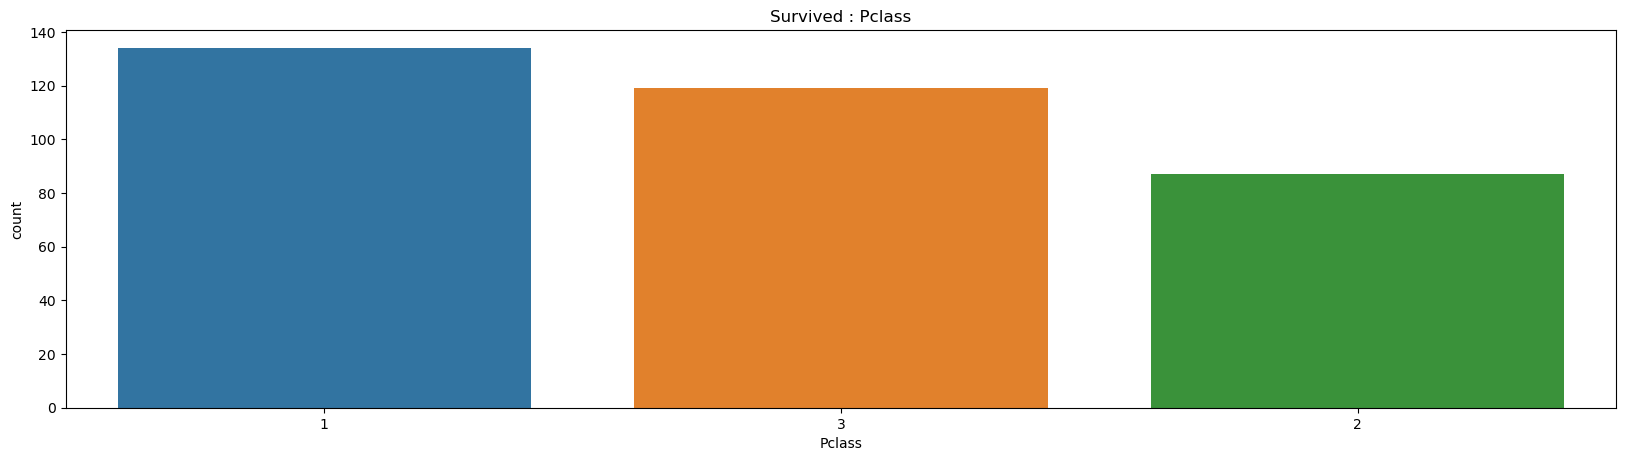

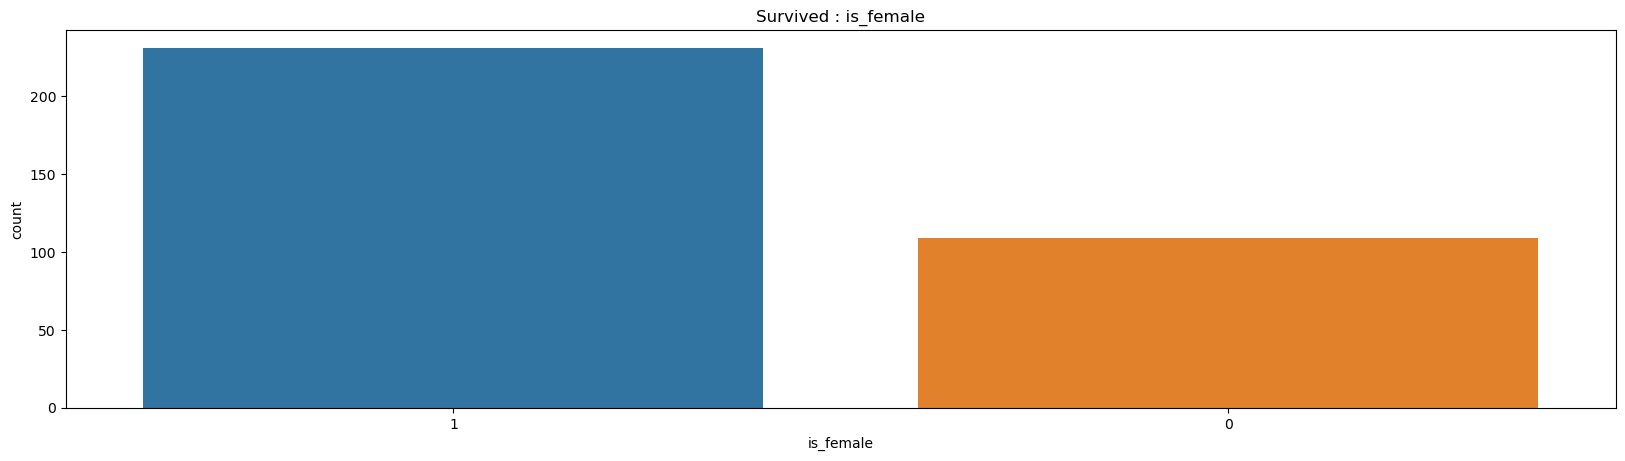

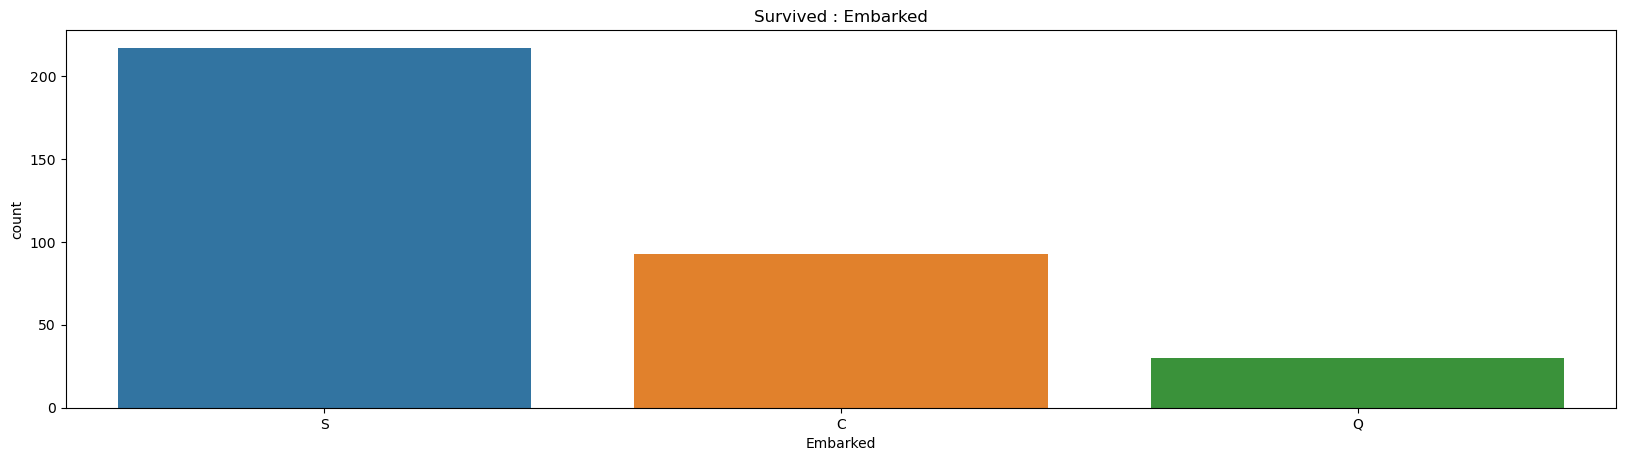

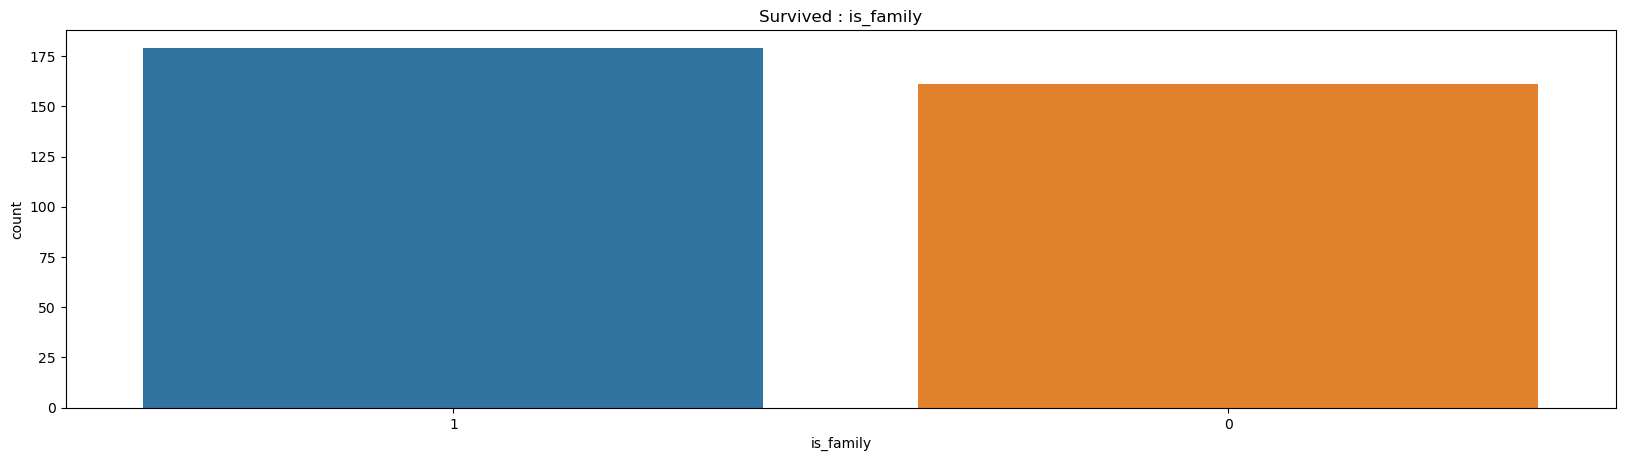

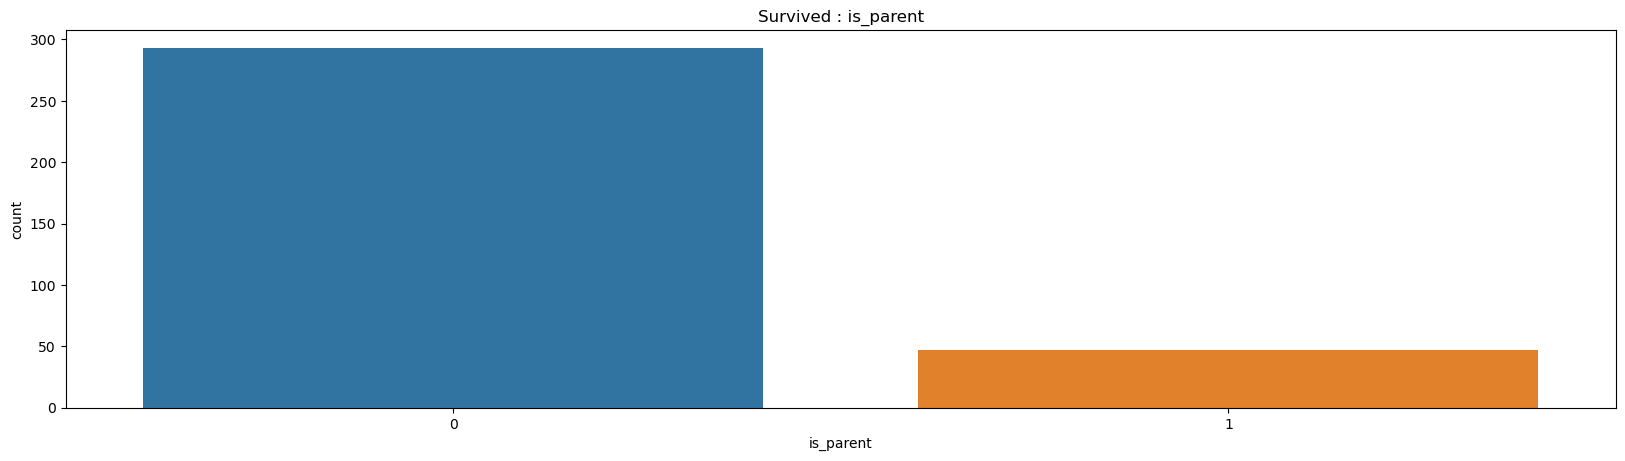

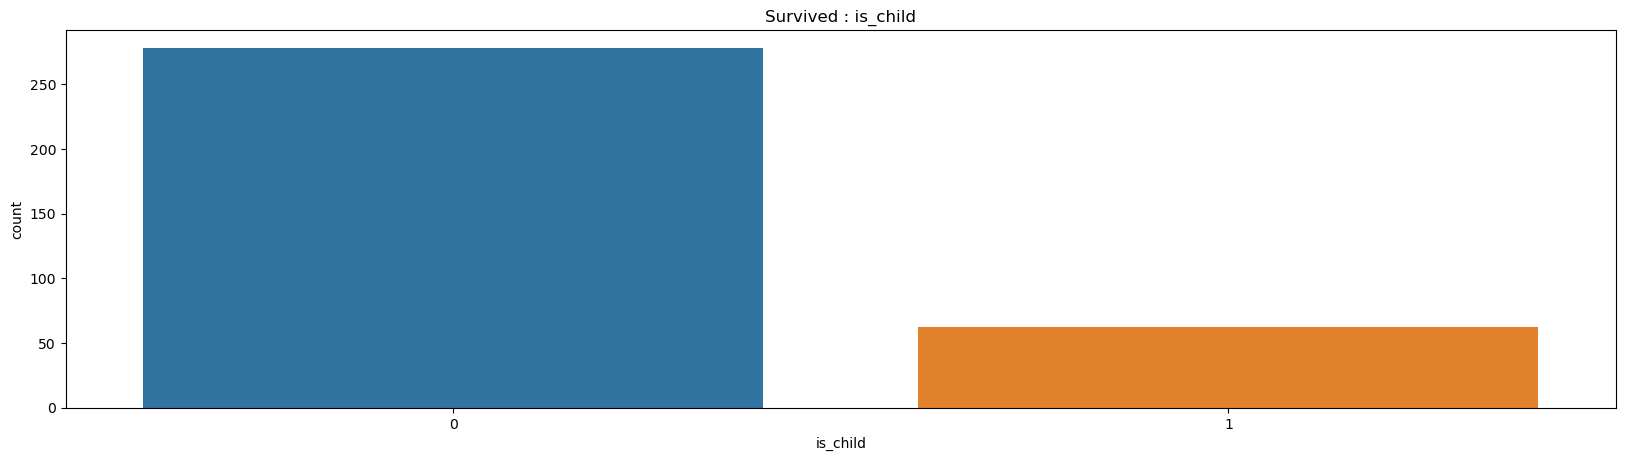

In [318]:
fields = ["Pclass","is_female","Embarked","is_family", "is_parent", "is_child"]
for field in fields:
    count_plot(surv_df, field)

## Fare and Age

These need to be bucketed to bring any meaning. First to find out what the values look like.

In [319]:
plt.figure(figsize=(20,5),dpi=100);
sns.displot(df, x="Age");

ValueError: Could not interpret value `Age` for parameter `x`

<Figure size 2000x500 with 0 Axes>

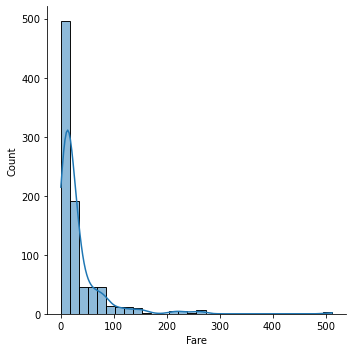

In [ ]:
sns.displot(df, x="Fare", bins=30, kde=True);

<AxesSubplot:>

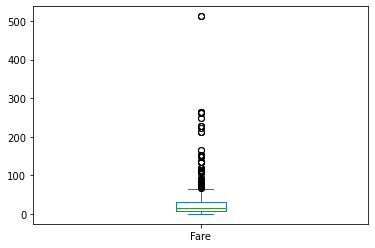

In [ ]:
df["Fare"].plot(kind="box")

In [320]:
df['Fare']

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 889, dtype: float64

In [331]:
bins = np.arange(0, 1000, 10)
in_bins = np.digitize(df['Fare'], bins, right=True)
in_bins

array([ 1,  8,  1,  6,  1,  1,  6,  3,  2,  4,  2,  3,  1,  4,  1,  2,  3,
        2,  2,  1,  3,  2,  1,  4,  3,  4,  1, 27,  1,  1,  3, 15,  1,  2,
        9,  6,  1,  1,  2,  2,  1,  3,  1,  5,  1,  1,  2,  1,  3,  2,  4,
        1,  8,  3,  7,  4,  2,  1,  3,  5,  1,  9,  3,  3,  2,  2,  1,  1,
        1,  2,  5,  8,  2,  6,  1,  1,  1,  3,  2,  1,  1,  1,  5,  2,  2,
        4,  1, 27,  1,  1,  1,  7,  3,  1,  1,  4,  7,  3,  3,  1,  1,  8,
        1,  1,  1,  1,  1,  1,  3,  6,  2,  1,  1,  2,  1,  1,  3, 25,  4,
        8,  1,  4,  2,  8,  2,  1,  1,  3,  1,  1,  1,  2,  3,  2,  2,  3,
        6,  1,  8,  2,  1,  2,  1,  2,  4,  1,  4,  3,  2,  2,  7,  1,  2,
        1,  7,  1,  1,  1,  7,  2,  2,  1,  1,  4,  3,  6,  3,  3,  6,  4,
        3,  2,  1,  4,  1,  3,  3,  2,  0,  7,  2,  4,  4,  3,  5,  2,  3,
        2,  1,  2,  2,  1,  3,  3, 15,  1,  1,  1,  2,  1,  7,  1,  1,  1,
        2,  2,  2,  1,  4,  1,  3,  1,  2,  1, 12,  1,  3,  8,  2,  1,  2,
        1,  1,  9,  1,  2

In [332]:
np.squeeze(in_bins)

array([ 1,  8,  1,  6,  1,  1,  6,  3,  2,  4,  2,  3,  1,  4,  1,  2,  3,
        2,  2,  1,  3,  2,  1,  4,  3,  4,  1, 27,  1,  1,  3, 15,  1,  2,
        9,  6,  1,  1,  2,  2,  1,  3,  1,  5,  1,  1,  2,  1,  3,  2,  4,
        1,  8,  3,  7,  4,  2,  1,  3,  5,  1,  9,  3,  3,  2,  2,  1,  1,
        1,  2,  5,  8,  2,  6,  1,  1,  1,  3,  2,  1,  1,  1,  5,  2,  2,
        4,  1, 27,  1,  1,  1,  7,  3,  1,  1,  4,  7,  3,  3,  1,  1,  8,
        1,  1,  1,  1,  1,  1,  3,  6,  2,  1,  1,  2,  1,  1,  3, 25,  4,
        8,  1,  4,  2,  8,  2,  1,  1,  3,  1,  1,  1,  2,  3,  2,  2,  3,
        6,  1,  8,  2,  1,  2,  1,  2,  4,  1,  4,  3,  2,  2,  7,  1,  2,
        1,  7,  1,  1,  1,  7,  2,  2,  1,  1,  4,  3,  6,  3,  3,  6,  4,
        3,  2,  1,  4,  1,  3,  3,  2,  0,  7,  2,  4,  4,  3,  5,  2,  3,
        2,  1,  2,  2,  1,  3,  3, 15,  1,  1,  1,  2,  1,  7,  1,  1,  1,
        2,  2,  2,  1,  4,  1,  3,  1,  2,  1, 12,  1,  3,  8,  2,  1,  2,
        1,  1,  9,  1,  2

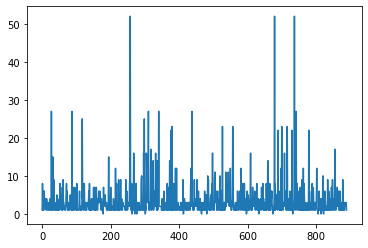

In [333]:
plt.plot(in_bins)

In [345]:
data = df['Fare']

In [357]:
bins = np.linspace(0, 600, 10)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_means

[17.947645173745162,
 86.07967162162164,
 146.25346666666667,
 238.1872529411765,
 nan,
 nan,
 nan,
 512.3292,
 nan]

In [364]:
list(bins)

[0.0,
 66.66666666666667,
 133.33333333333334,
 200.0,
 266.6666666666667,
 333.33333333333337,
 400.0,
 466.6666666666667,
 533.3333333333334,
 600.0]

<AxesSubplot:>

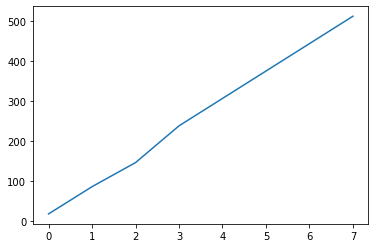

In [371]:
sns.lineplot(data=bin_means) 

In [350]:
bin_means = (np.histogram(data, bins, weights=data)[0], np.histogram(data, bins)[0])
bin_means

(array([2525.0203, 2484.4499, 3450.9583, 2170.7374,  684.271 , 2118.7917,
        1136.5417, 2220.9459, 1100.3332,  729.1584,  430.65  ,  783.3582,
         480.    ,  943.1999,  293.0416, 1066.5875,  329.7334,    0.    ,
           0.    ,    0.    ,    0.    ,  845.5125, 1131.8792,    0.    ,
         495.0416,    0.    , 1576.75  ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    , 1536.9876,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.   

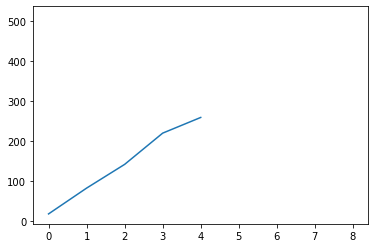

In [347]:
from scipy.stats import binned_statistic
bin_means = binned_statistic(df['Fare'], df['Fare'], bins=10, range=(0, 600))[0]
plt.plot(bin_means)

In [341]:
bin_means

array([ 17.4697381 ,  82.06394103, 141.48010909, 219.71018889,
       258.97395   ,          nan,          nan,          nan,
       512.3292    ,          nan])